In [1]:
import re
import pandas as pd
from datetime import datetime, timedelta,date
import numpy as np
import json
import os
from calendar import monthrange
import pymysql
import sys 
import requests
import matplotlib.pyplot as plt
from elasticsearch.helpers import scan
import seaborn as sns 
import datetime as dt
import xlsxwriter

In [2]:
df=pd.read_excel('C:/Users/PC/Downloads/KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerDemographic',header=1,index_col=0)
df

C:\Users\PC\AppData\Local\Temp\ipykernel_17152\3962452623.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df=pd.read_excel('C:/Users/PC/Downloads/KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerDemographic',header=1,index_col=0)


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
customer_id,,,,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3996,Rosalia,Halgarth,Female,8,1975-08-09,VP Product Management,Health,Mass Customer,N,-100,No,19.0
3997,Blanch,Nisuis,Female,87,2001-07-13,Statistician II,Manufacturing,High Net Worth,N,â¦testâ§,Yes,1.0
3998,Sarene,Woolley,U,60,NaT,Assistant Manager,IT,High Net Worth,N,NaN,No,NaN


In [3]:
df = df.drop(['first_name', 'last_name', 'default', 'job_title'],axis=1)
df['gender'].replace(['F', 'Femal'], 'Female', inplace=True)
df['gender'].replace('M', 'Male', inplace=True)
df['gender'].replace('U', 'Unknown', inplace=True)
df['deceased_indicator'].replace(['N'], 0, inplace=True)
df['deceased_indicator'].replace(['Y'], 1, inplace=True)
df['owns_car'].replace('Yes', 1, inplace=True)
df['owns_car'].replace('No', 0, inplace=True)
# df = df[demo_df['DOB'] != df.DOB.min()]
df[df['deceased_indicator'] == 0]
df[(df['gender']=='Female')|(df['gender']=='Male')]
df = df.drop(['deceased_indicator'], axis=1)
df.drop(df[df['gender'] == 'Unknown'].index, inplace = True)
df_clean = df.dropna()
df_clean.head()

,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure
customer_id,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0
3,Male,61,1954-01-20,Property,Mass Customer,1,15.0
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0


In [4]:
df_clean['age']=date.today().year - df['DOB'].dt.year
df_clean

C:\Users\PC\AppData\Local\Temp\ipykernel_17152\3359780616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age']=date.today().year - df['DOB'].dt.year


,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age
customer_id,,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0,69
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0,42
3,Male,61,1954-01-20,Property,Mass Customer,1,15.0,68
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0,61
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0,56
...,...,...,...,...,...,...,...,...
3994,Female,5,1989-04-07,Manufacturing,Affluent Customer,0,12.0,33
3995,Male,93,1975-12-12,Manufacturing,Mass Customer,1,14.0,47
3996,Female,8,1975-08-09,Health,Mass Customer,0,19.0,47


In [5]:
df2=pd.read_excel('C:/Users/PC/Downloads/KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerAddress',header=1,index_col=0)
df2

,address,postcode,state,country,property_valuation
customer_id,,,,,
1,060 Morning Avenue,2016,New South Wales,Australia,10
2,6 Meadow Vale Court,2153,New South Wales,Australia,10
4,0 Holy Cross Court,4211,QLD,Australia,9
5,17979 Del Mar Point,2448,New South Wales,Australia,4
6,9 Oakridge Court,3216,VIC,Australia,9
...,...,...,...,...,...
3999,1482 Hauk Trail,3064,VIC,Australia,3
4000,57042 Village Green Point,4511,QLD,Australia,6
4001,87 Crescent Oaks Alley,2756,NSW,Australia,10


In [6]:
df2['state'].replace('New South Wales','NSW',inplace=True)
df2['state'].replace('Victoria', 'VIC', inplace=True)
df2_clean = df2.dropna()
df2_clean 

,address,postcode,state,country,property_valuation
customer_id,,,,,
1,060 Morning Avenue,2016,NSW,Australia,10
2,6 Meadow Vale Court,2153,NSW,Australia,10
4,0 Holy Cross Court,4211,QLD,Australia,9
5,17979 Del Mar Point,2448,NSW,Australia,4
6,9 Oakridge Court,3216,VIC,Australia,9
...,...,...,...,...,...
3999,1482 Hauk Trail,3064,VIC,Australia,3
4000,57042 Village Green Point,4511,QLD,Australia,6
4001,87 Crescent Oaks Alley,2756,NSW,Australia,10


In [7]:
merge_df=df_clean.merge(df2_clean,how='inner',on='customer_id')
merge_df=merge_df.dropna()
merge_df 

,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,address,postcode,state,country,property_valuation
customer_id,,,,,,,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0,69,060 Morning Avenue,2016,NSW,Australia,10
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0,42,6 Meadow Vale Court,2153,NSW,Australia,10
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0,61,0 Holy Cross Court,4211,QLD,Australia,9
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0,56,9 Oakridge Court,3216,VIC,Australia,9
7,Female,6,1976-02-23,Financial Services,Affluent Customer,1,11.0,46,4 Delaware Trail,2210,NSW,Australia,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,Female,5,1989-04-07,Manufacturing,Affluent Customer,0,12.0,33,2918 Summer Ridge Hill,3030,VIC,Australia,2
3995,Male,93,1975-12-12,Manufacturing,Mass Customer,1,14.0,47,613 Erie Lane,2088,NSW,Australia,12
3996,Female,8,1975-08-09,Health,Mass Customer,0,19.0,47,0 Transport Center,3977,VIC,Australia,6


In [8]:
df3=pd.read_excel('C:/Users/PC/Downloads/KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='Transactions',header=1,index_col=0)
df3=df3.sort_values('customer_id')
df3 

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.880000,33455.0
18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.960000,35378.0
16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.400000,37838.0
5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.420000,37823.0
13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.620000,38573.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2463,2,3500,2017-04-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.620000,41245.0
8416,74,3500,2017-02-16,0.0,Approved,WeareA2B,Standard,medium,medium,1228.07,400.910000,36668.0
8708,0,5034,2017-10-07,0.0,Approved,Solex,Road,medium,medium,416.98,312.735016,42218.0


In [9]:
df3['product_first_sold_date'] = pd.TimedeltaIndex(df3['product_first_sold_date'], unit='d') + dt.datetime(1900,1,1)
df3=df3.dropna()
df3['profit']=df3['list_price']-df3['standard_cost']
df3['last_purchase_day_ago']=df3['transaction_date'].max()-df3['transaction_date']
df3['last_purchase_day_ago']/=np.timedelta64(1, 'D')
df3['month'] = df3['transaction_date'].dt.month
df3.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_17152\2666861678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['profit']=df3['list_price']-df3['standard_cost']
C:\Users\PC\AppData\Local\Temp\ipykernel_17152\2666861678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['last_purchase_day_ago']=df3['transaction_date'].max()-df3['transaction_date']
C:\Users\PC\AppData\Local\Temp\ipykernel_17152\2666861678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit,last_purchase_day_ago,month
transaction_id,,,,,,,,,,,,,,,
14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,1991-08-07,75.75,278.0,3
18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,1996-11-11,509.97,276.0,3
16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,2003-08-07,75.14,21.0,12
5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-23,189.28,233.0,5
13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-11,17.87,312.0,2


In [10]:
df3_new = df3.groupby('customer_id').agg({
    'last_purchase_day_ago': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'profit': lambda x: x.sum()
})

df3_new.rename(columns={
    'last_purchase_day_ago':'recency',
    'customer_id': 'frequency'
    }, inplace=True
)
df3_new

,recency,frequency,profit
customer_id,,,
1,7.0,11,3018.090000
2,128.0,3,2226.260000
3,102.0,7,3290.210000
4,195.0,2,220.570000
5,16.0,6,2394.940000
...,...,...,...
3497,52.0,3,1648.320000
3498,127.0,6,3147.330000
3499,51.0,7,4955.250000


In [11]:
def set_rank(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else: 
        return 4
    
def set_rank2(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else: 
        return 1
quartiles = df3_new.quantile(q=[0.25,0.50,0.75])

In [12]:
df3_new['r_rank']= df3_new['recency'].apply(set_rank,args=('recency',quartiles))
df3_new['f_rank'] = df3_new['frequency'].apply(set_rank2, args=('frequency', quartiles))
df3_new['p_rank'] = df3_new['profit'].apply(set_rank2, args=('profit', quartiles))

In [13]:
df3_new 

,recency,frequency,profit,r_rank,f_rank,p_rank
customer_id,,,,,,
1,7.0,11,3018.090000,1,1,2
2,128.0,3,2226.260000,4,4,3
3,102.0,7,3290.210000,4,2,2
4,195.0,2,220.570000,4,4,4
5,16.0,6,2394.940000,1,2,3
...,...,...,...,...,...,...
3497,52.0,3,1648.320000,3,4,4
3498,127.0,6,3147.330000,4,2,2
3499,51.0,7,4955.250000,3,2,1


In [14]:
df3_new['rfm_point']=df3_new['r_rank']*100 + df3_new['f_rank']*10+df3_new['p_rank'] 
df3_new['total_point']=df3_new['r_rank'] + df3_new['f_rank']+df3_new['p_rank'] 
df3_new.head()

,recency,frequency,profit,r_rank,f_rank,p_rank,rfm_point,total_point
customer_id,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,4
2,128.0,3,2226.26,4,4,3,443,11
3,102.0,7,3290.21,4,2,2,422,8
4,195.0,2,220.57,4,4,4,444,12
5,16.0,6,2394.94,1,2,3,123,6


In [15]:
customer_quartiles=(df3_new['rfm_point'].min(), df3_new['rfm_point'].quantile(q=0.25),
                 df3_new['rfm_point'].median(),df3_new['rfm_point'].quantile(q=0.75), 
                 df3_new['rfm_point'].max())
def set_rank_customer(x, p, d):
    if x <= d[0]:
        return 'gold'
    elif x <= d[1]:
        return 'silver'
    elif x <= d[2]: 
        return 'bronze'
    else: 
        return 'basic'
df3_new['customer_rank']=df3_new['rfm_point'].apply(set_rank_customer,args=('rfm_point',customer_quartiles))
df3_new 

,recency,frequency,profit,r_rank,f_rank,p_rank,rfm_point,total_point,customer_rank
customer_id,,,,,,,,,
1,7.0,11,3018.090000,1,1,2,112,4,silver
2,128.0,3,2226.260000,4,4,3,443,11,basic
3,102.0,7,3290.210000,4,2,2,422,8,basic
4,195.0,2,220.570000,4,4,4,444,12,basic
5,16.0,6,2394.940000,1,2,3,123,6,silver
...,...,...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,3,4,4,344,11,basic
3498,127.0,6,3147.330000,4,2,2,422,8,basic
3499,51.0,7,4955.250000,3,2,1,321,6,basic


In [16]:
final_merge=df3_new.merge(merge_df,how='inner',on='customer_id')
final_merge 

,recency,frequency,profit,r_rank,f_rank,p_rank,rfm_point,total_point,customer_rank,gender,...,job_industry_category,wealth_segment,owns_car,tenure,age,address,postcode,state,country,property_valuation
customer_id,,,,,,,,,,,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,4,silver,Female,...,Health,Mass Customer,1,11.0,69,060 Morning Avenue,2016,NSW,Australia,10
2,128.0,3,2226.26,4,4,3,443,11,basic,Male,...,Financial Services,Mass Customer,1,16.0,42,6 Meadow Vale Court,2153,NSW,Australia,10
4,195.0,2,220.57,4,4,4,444,12,basic,Male,...,IT,Mass Customer,0,7.0,61,0 Holy Cross Court,4211,QLD,Australia,9
6,64.0,5,3946.55,3,3,2,332,8,basic,Male,...,Retail,High Net Worth,1,13.0,56,9 Oakridge Court,3216,VIC,Australia,9
7,253.0,3,220.11,4,4,4,444,12,basic,Female,...,Financial Services,Affluent Customer,1,11.0,46,4 Delaware Trail,2210,NSW,Australia,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,256.0,4,2045.84,4,4,3,443,11,basic,Male,...,Manufacturing,Mass Customer,1,19.0,36,2565 Caliangt Point,2171,NSW,Australia,9
3497,52.0,3,1648.32,3,4,4,344,11,basic,Female,...,Manufacturing,Affluent Customer,1,18.0,36,96 Delladonna Trail,3976,VIC,Australia,5
3498,127.0,6,3147.33,4,2,2,422,8,basic,Female,...,Manufacturing,Mass Customer,0,5.0,27,3 Nova Point,3012,VIC,Australia,4


#### Phân bố khách hàng theo rank 

Text(0.5, 1.0, 'Customer with rank distribution')

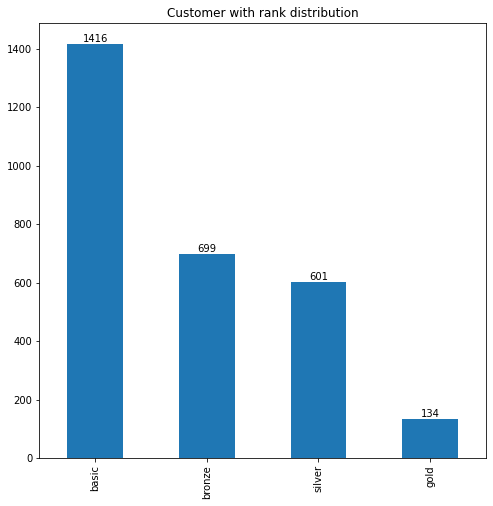

In [17]:
ax=final_merge['customer_rank'].value_counts().plot.bar(figsize=(8,8))
for i in ax.containers:
    ax.bar_label(i)
plt.title('Customer with rank distribution')

#### Phân bố giữa lợi nhuận và tần suất mua hàng

<AxesSubplot:xlabel='frequency', ylabel='profit'>

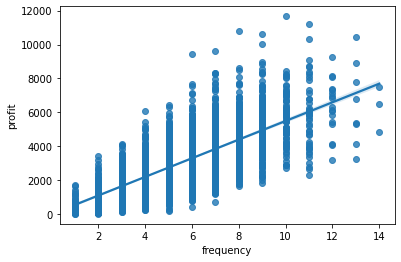

In [18]:
sns.regplot(x=final_merge['frequency'],y=final_merge['profit'])

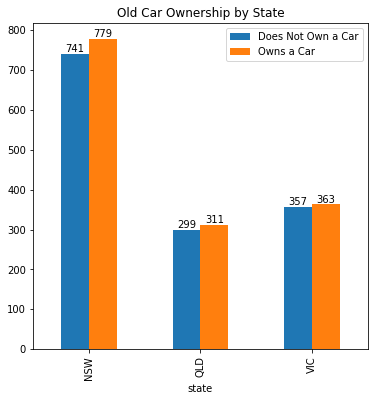

In [19]:
ax=final_merge.groupby('state')['owns_car'].value_counts().unstack(level=1).plot.bar(stacked=False,figsize=(6,6))
for i in ax.containers:
    ax.bar_label(i)
plt.title('Old Car Ownership by State')
plt.legend(['Does Not Own a Car', 'Owns a Car'])
plt.show()

#### Phân bổ tài chính khách hàng theo giới tính

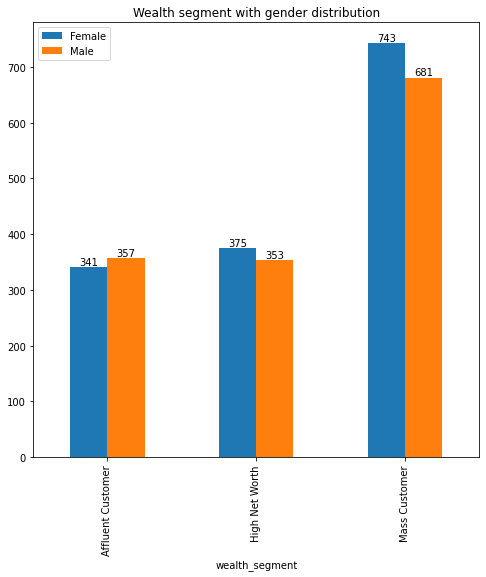

In [20]:
ax=final_merge.groupby('wealth_segment')['gender'].value_counts().unstack(level=1).plot.bar(stacked=False,figsize=(8,8))
for i in ax.containers:
    ax.bar_label(i)
plt.title('Wealth segment with gender distribution')
plt.legend(['Female', 'Male'])
plt.show()

#### Rank khách hàng theo bang

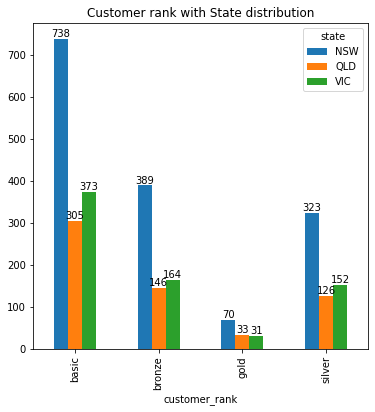

In [21]:
ax=final_merge.groupby('customer_rank')['state'].value_counts().unstack(level=1).plot.bar(stacked=False,figsize=(6,6))
for i in ax.containers:
    ax.bar_label(i)
plt.title('Customer rank with State distribution')
plt.show()

#### Phân bố tuổi của khách hàng 

(array([340., 340., 340., 804., 388., 339., 294.,   0.,   3.,   2.]),
 array([20. , 27.1, 34.2, 41.3, 48.4, 55.5, 62.6, 69.7, 76.8, 83.9, 91. ]),
 <BarContainer object of 10 artists>)

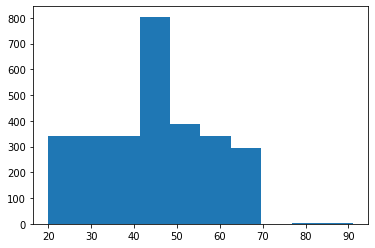

In [22]:
plt.hist(final_merge['age'])

#### Tỉ lệ khách hàng theo từng nhóm ngành nghề 

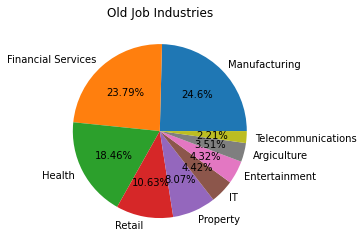

In [23]:
final_merge['job_industry_category'].value_counts().plot.pie(autopct=lambda pct: str(round(pct, 2)) + '%')
plt.title('Old Job Industries')
plt.ylabel('')
plt.show()

#### Số lượng sở hữu oto theo từng ngành nghề của khách hàng

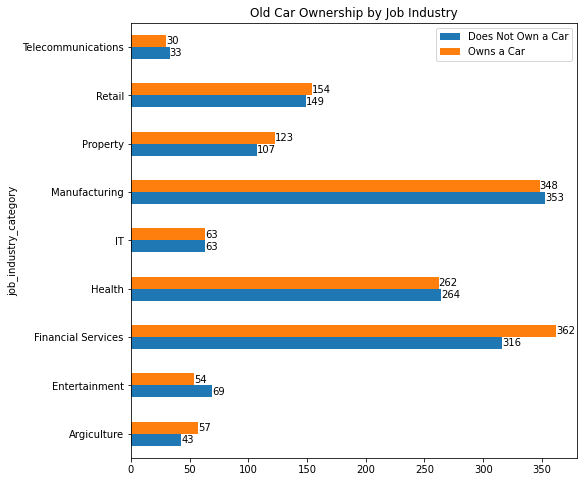

In [24]:
ax=final_merge.groupby('job_industry_category')['owns_car'].value_counts().unstack(level=1).plot.barh(stacked=False,figsize=(8,8))
for i in ax.containers:
    ax.bar_label(i)
plt.title('Old Car Ownership by Job Industry')
plt.legend(['Does Not Own a Car', 'Owns a Car'])
plt.show()

#### Lợi nhuận theo từng bang

Text(0.5, 1.0, 'Profit with state distribution')

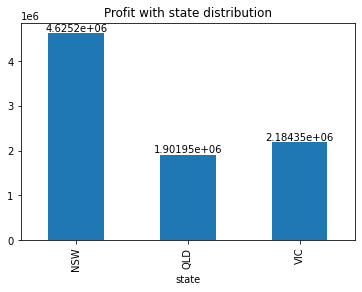

In [25]:
ax=final_merge.groupby('state')['profit'].sum().plot.bar()
for i in ax.containers:
    ax.bar_label(i)
plt.title('Profit with state distribution')

#### Phân bố giữa lợi nhuận và tuổi khách hàng

<AxesSubplot:xlabel='age', ylabel='profit'>

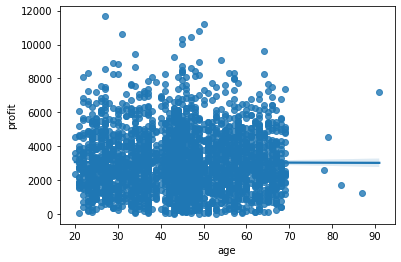

In [26]:
sns.regplot(x=final_merge['age'],y=final_merge['profit'])

#### Phân bố khách hàng theo bang và rank 

In [27]:
final_merge.pivot_table(index='state',columns='customer_rank',values='age',aggfunc='count')

customer_rank,basic,bronze,gold,silver
state,,,,
NSW,738,389,70,323
QLD,305,146,33,126
VIC,373,164,31,152


#### Top 1000 Khách hàng tiềm năng nhất

In [28]:
final_merge['customer_segment'] = final_merge['total_point'].map({
    3: 'Core',
    4: 'Loyal',
    5: 'Promising',
    6: 'Promising',
    7: 'Promising',
    8: 'High Risk',
    9: 'High Risk',
    10: 'Slipping',
    11: 'Slipping',
    12: 'Slipping'
})

In [29]:
top_1000=final_merge.sort_values('rfm_point').head(1000)
top_1000

,recency,frequency,profit,r_rank,f_rank,p_rank,rfm_point,total_point,customer_rank,gender,...,wealth_segment,owns_car,tenure,age,address,postcode,state,country,property_valuation,customer_segment
customer_id,,,,,,,,,,,,,,,,,,,,,
2308,13.0,9,5077.97,1,1,1,111,3,gold,Female,...,Mass Customer,1,17.0,59,00 Marcy Crossing,3115,VIC,Australia,9,Core
1091,4.0,10,4183.81,1,1,1,111,3,gold,Male,...,Mass Customer,0,15.0,42,0 Fremont Court,3023,VIC,Australia,7,Core
2340,5.0,9,4585.40,1,1,1,111,3,gold,Male,...,Mass Customer,1,16.0,44,29 Portage Street,4070,QLD,Australia,7,Core
1942,16.0,8,4675.19,1,1,1,111,3,gold,Male,...,High Net Worth,0,19.0,35,184 Hoepker Way,2197,NSW,Australia,9,Core
346,12.0,9,6420.70,1,1,1,111,3,gold,Male,...,Mass Customer,0,3.0,41,44621 Linden Drive,2155,NSW,Australia,10,Core
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,38.0,6,3372.13,2,2,2,222,6,bronze,Female,...,High Net Worth,1,4.0,24,20415 Clyde Gallagher Parkway,2333,NSW,Australia,5,Promising
2179,36.0,7,3631.27,2,2,2,222,6,bronze,Male,...,Mass Customer,0,17.0,62,966 Emmet Trail,3015,VIC,Australia,10,Promising
2544,32.0,6,3044.80,2,2,2,222,6,bronze,Male,...,Mass Customer,1,16.0,34,440 Ronald Regan Pass,2261,NSW,Australia,7,Promising


In [33]:
# writer = pd.ExcelWriter('top1000.xlsx',engine = 'xlsxwriter')
# top_1000.to_excel(writer, sheet_name = 'dataset')
# writer.save()
# writer.close()

In [32]:
# writer2 = pd.ExcelWriter('transaction.xlsx',engine = 'xlsxwriter')
# df3.to_excel(writer2, sheet_name = 'transaction')
# writer2.save()
# writer2.close()

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
